# Loading

In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import helper as hp

import os
from abc import ABC, abstractmethod
from collections import defaultdict
import warnings

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mplfinance as mpf
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from statsmodels.tsa.stattools import adfuller, kpss
from models import * 

current_path = os.getcwd()
random_state = hp.RANDOM_STATE

current_path = os.getcwd()
random_state = hp.RANDOM_STATE
STOCKS = ["TSLA", "AAPL", 'QQQ', "SPY", "MSFT", "AMZN", "GOOG", "DIA", "^IRX"]
START_DATE = hp.START_DATE
END_DATE = hp.END_DATE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# data fetching 
stock_data = {}
for stock in STOCKS:
    data_path = os.path.join(current_path, "data", f"{stock}_{START_DATE}_{END_DATE}.csv")
    data = pd.read_csv(data_path)
    stock_data[stock] = data
stock_data = hp.preprocess_stock_data(stock_data, STOCKS)

Data fetched for TSLA
Data fetched for AAPL
Data fetched for QQQ
Data fetched for SPY
Data fetched for MSFT
Data fetched for AMZN
Data fetched for GOOG
Data fetched for DIA
Data fetched for ^IRX


## Paramenters

In [4]:
fromDate = "2015-01-01"
toDate = '2023-01-01'
# fromDate = "2015-01-01"
# toDate = '2017-01-01'
STOCK = 'AAPL'
lag = 5
window_size = 10
starting_funds = 50000

# Non-Stationary

In [5]:
stationary = False
X, y, df_stock = hp.prepare_data(stock_data, STOCK, fromDate, toDate, lag, stationary=stationary)

## XGBoost

In [8]:
loss_fn = 'reg:squarederror' #'reg:squaredlogerror'
xgboost_model = XGBoost(loss_fn)
xgboost_stock_predictor = StockPredictor(xgboost_model, window_size=window_size, stationary=stationary)
xgboost_stock_predictor.fit_predict(X, y, df_stock)
xgboost_stock_predictor.print_metrics()

Processing: 100%|██████████| 1986/1986 [00:58<00:00, 33.83it/s]

Mean Squared Error (MSE): 7.6891
Mean Absolute Error (MAE): 1.9072


1.9071572408630553

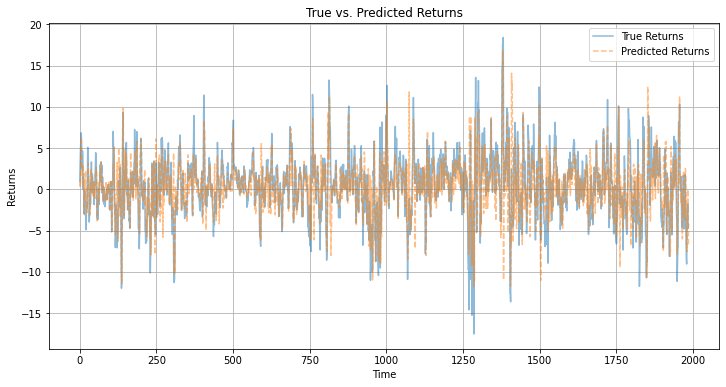

In [9]:
true_returns = xgboost_stock_predictor.true_returns
predicted_returns = xgboost_stock_predictor.predicted_returns
plt.figure(figsize=(12, 6))
plt.plot(true_returns, label='True Returns', linestyle='-', alpha=0.5)
plt.plot(predicted_returns, label='Predicted Returns', linestyle='--', alpha=0.5)
plt.title('True vs. Predicted Returns')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid(True)
plt.show()


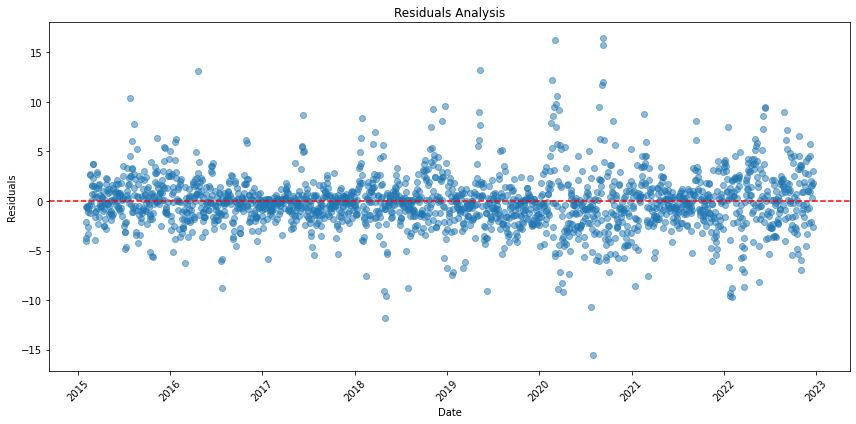

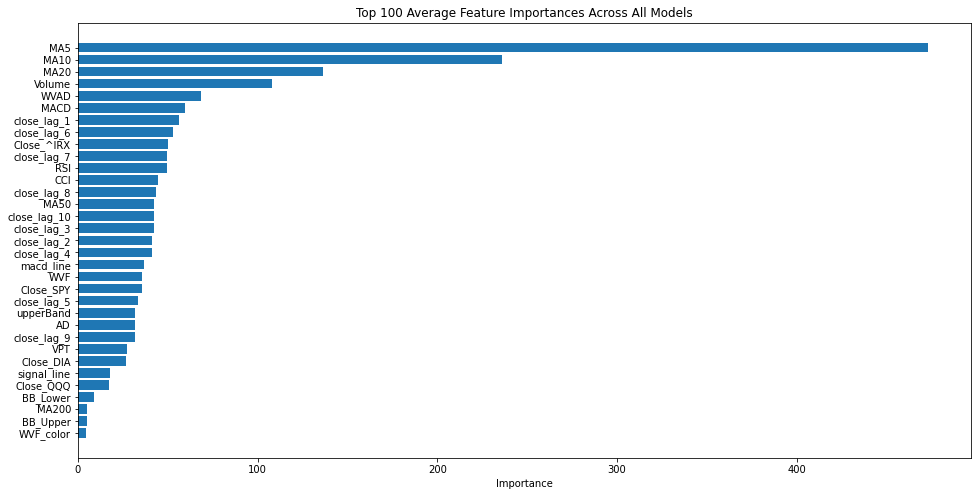

In [10]:
xgboost_stock_predictor.plot_residuals()
xgboost_stock_predictor.show_feature_importance(n=100)

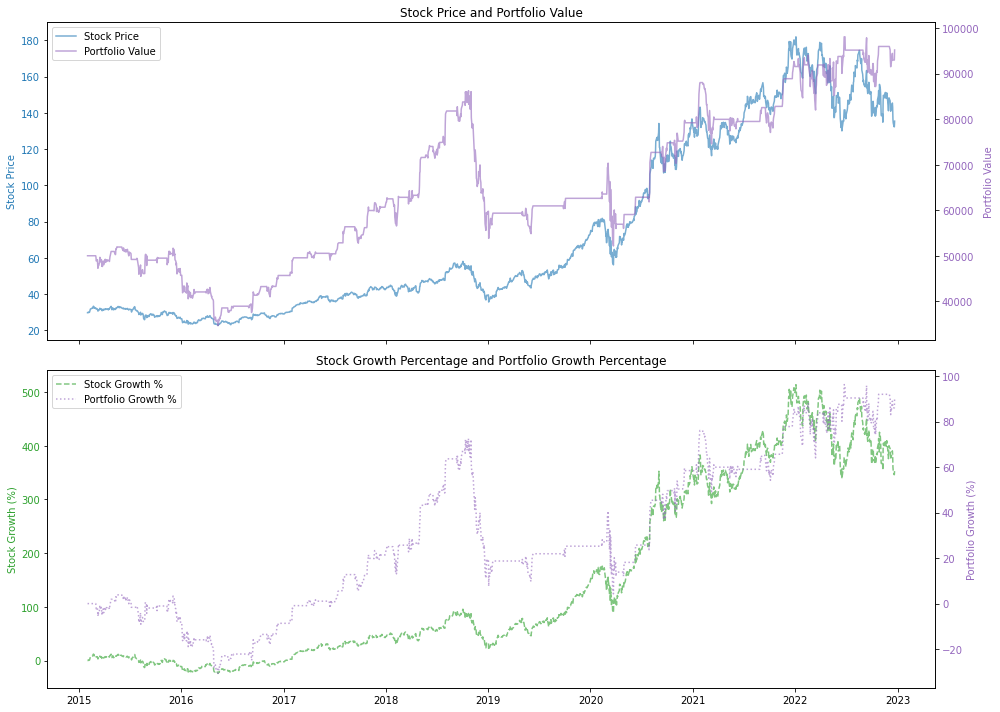

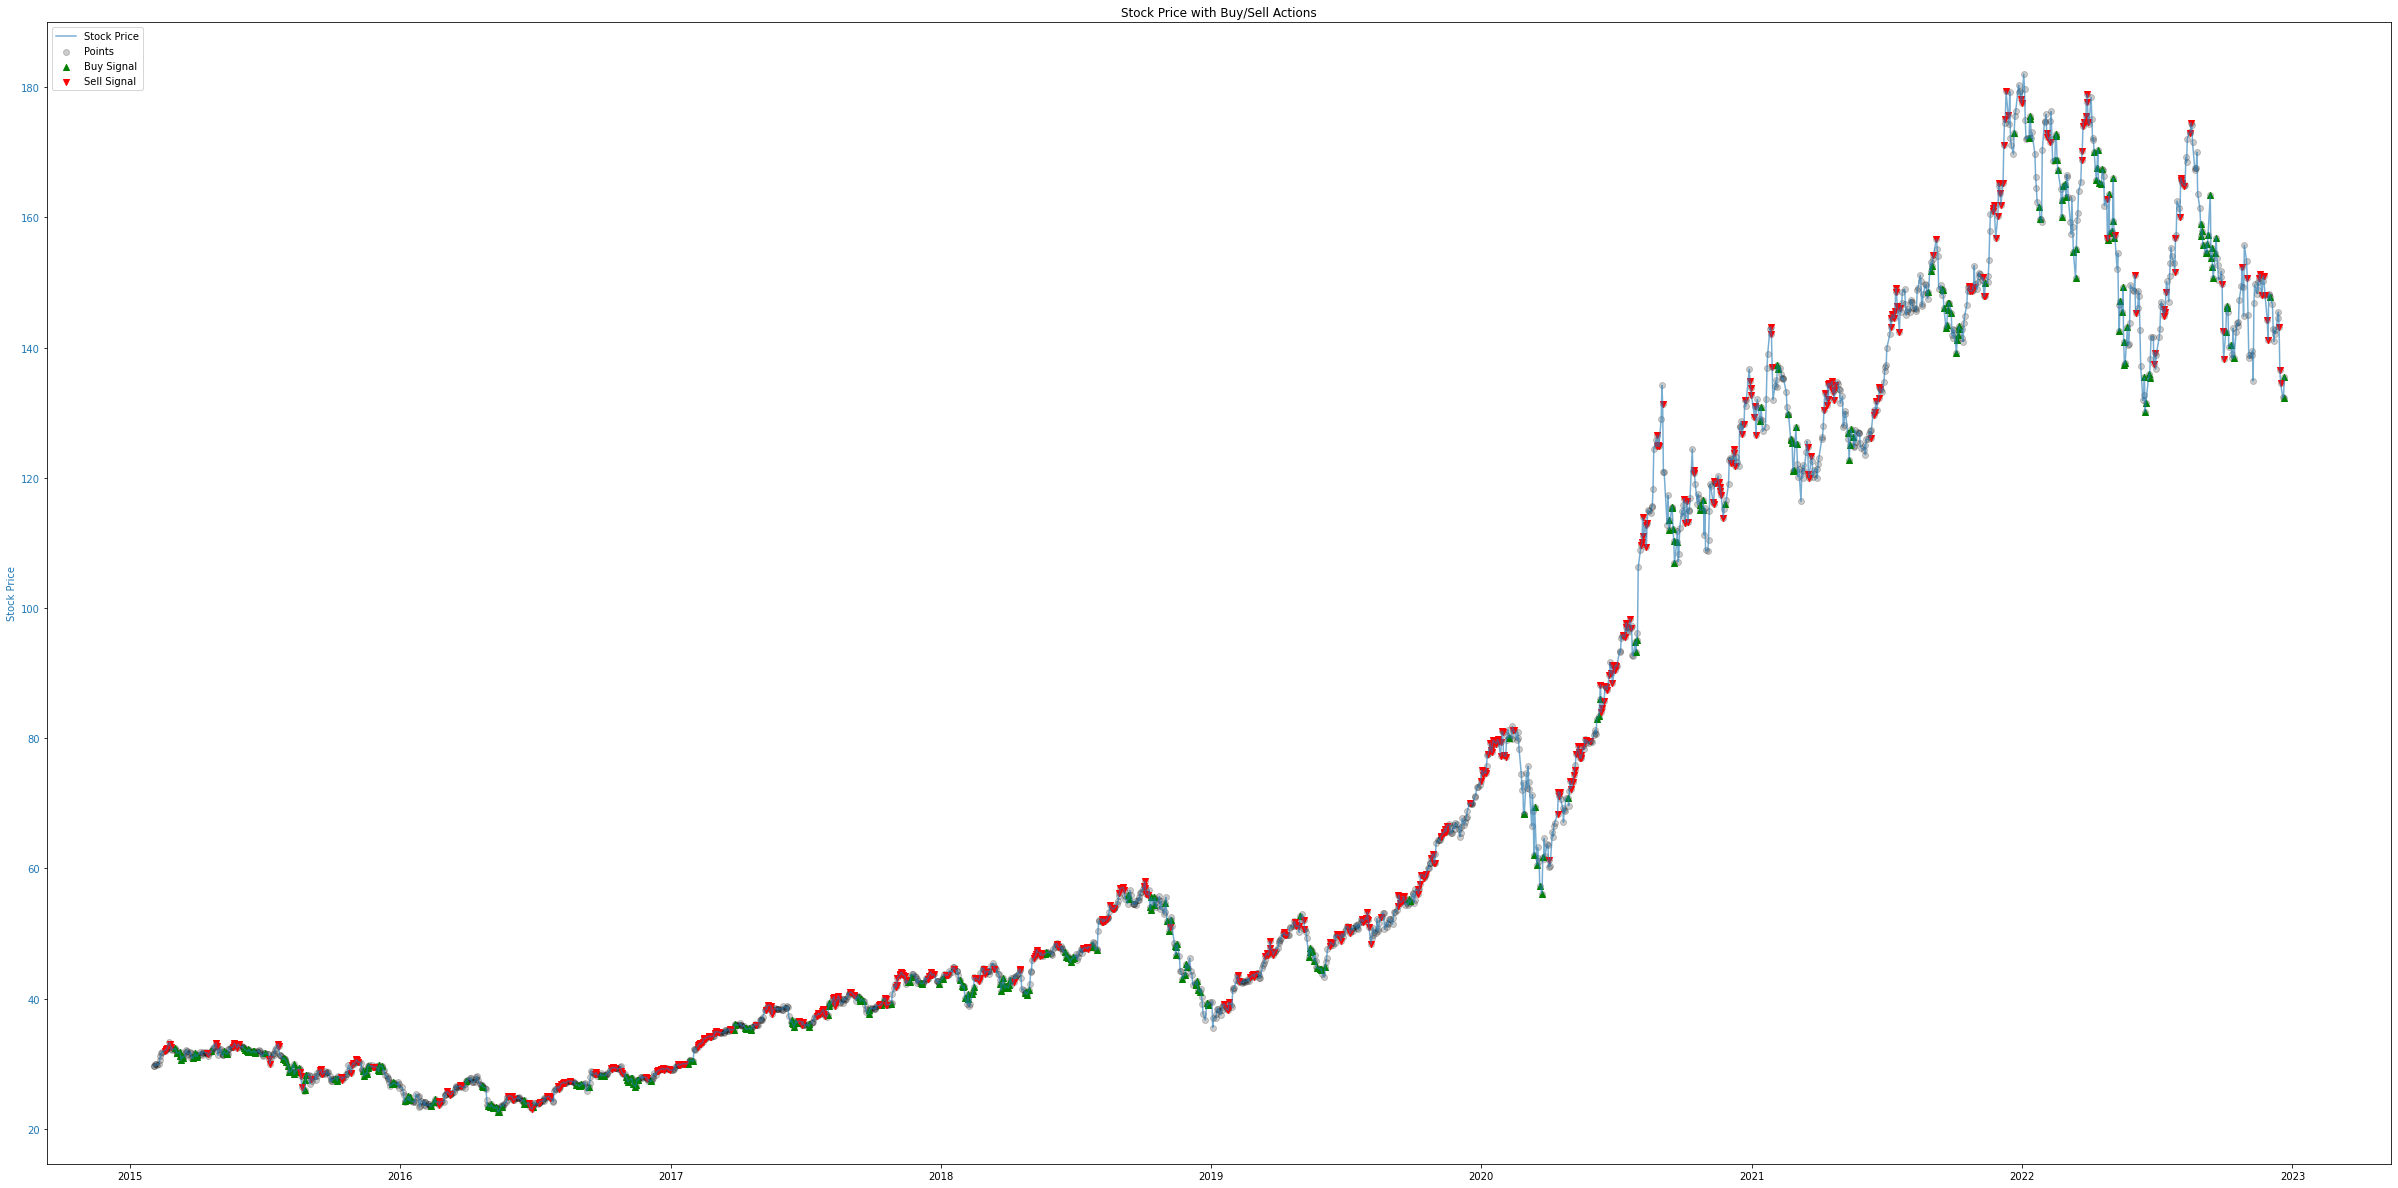

In [11]:
hp.trading_strategy(df_stock=df_stock, window_size=window_size, 
    true_returns=xgboost_stock_predictor.true_returns,
    predicted_returns=xgboost_stock_predictor.predicted_returns,
    starting_funds=50000
)

### Hyperparameter Tunning

In [15]:
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 6),
        'gamma': trial.suggest_float('gamma', 0.1, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 1.0, log=True)
    }
    loss_fn = 'reg:squarederror' #'reg:pseudohubererror'
    xgboost_model = XGBoost(loss_fn, params)
    xgboost_stock_predictor = StockPredictor(xgboost_model, window_size=window_size, stationary=stationary)
    xgboost_stock_predictor.fit_predict(X, y, df_stock)
    return xgboost_stock_predictor.print_metrics()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-11-26 22:41:16,018] A new study created in memory with name: no-name-6d2eff44-a122-4b88-b8ff-3bb9145c310e
Processing: 100%|██████████| 1986/1986 [02:00<00:00, 16.45it/s]
[I 2023-11-26 22:43:16,724] Trial 0 finished with value: 2.0666417317164365 and parameters: {'n_estimators': 295, 'max_depth': 3, 'min_child_weight': 4, 'gamma': 0.5705896984374621, 'learning_rate': 0.07918942288954987, 'subsample': 0.8363809617476752, 'colsample_bytree': 0.9289926962933633, 'reg_alpha': 0.4985405612929691, 'reg_lambda': 0.12316812748477574}. Best is trial 0 with value: 2.0666417317164365.


Mean Squared Error (MSE): 7.3498
Mean Absolute Error (MAE): 2.0666


Processing: 100%|██████████| 1986/1986 [02:13<00:00, 14.89it/s]
[I 2023-11-26 22:45:30,097] Trial 1 finished with value: 2.688981798546783 and parameters: {'n_estimators': 356, 'max_depth': 4, 'min_child_weight': 6, 'gamma': 0.5991006792371154, 'learning_rate': 0.07612994523101423, 'subsample': 0.8961553888218652, 'colsample_bytree': 0.9112584340770313, 'reg_alpha': 0.0527380555721165, 'reg_lambda': 0.0003175741449990075}. Best is trial 0 with value: 2.0666417317164365.


Mean Squared Error (MSE): 12.1970
Mean Absolute Error (MAE): 2.6890


Processing: 100%|██████████| 1986/1986 [01:42<00:00, 19.47it/s]
[I 2023-11-26 22:47:12,130] Trial 2 finished with value: 1.8943743451863535 and parameters: {'n_estimators': 239, 'max_depth': 7, 'min_child_weight': 4, 'gamma': 0.2060573433377163, 'learning_rate': 0.06267458555050395, 'subsample': 0.6746826986213214, 'colsample_bytree': 0.9270395813879955, 'reg_alpha': 0.0077293323190843035, 'reg_lambda': 0.2884903860835927}. Best is trial 2 with value: 1.8943743451863535.


Mean Squared Error (MSE): 6.4900
Mean Absolute Error (MAE): 1.8944


Processing: 100%|██████████| 1986/1986 [02:44<00:00, 12.06it/s]
[I 2023-11-26 22:49:56,813] Trial 3 finished with value: 2.231622723839136 and parameters: {'n_estimators': 458, 'max_depth': 6, 'min_child_weight': 5, 'gamma': 0.40872011288486043, 'learning_rate': 0.06275834652492064, 'subsample': 0.7068361031811492, 'colsample_bytree': 0.7504916804651208, 'reg_alpha': 0.0023407103414743438, 'reg_lambda': 0.0002829924657414409}. Best is trial 2 with value: 1.8943743451863535.


Mean Squared Error (MSE): 8.6868
Mean Absolute Error (MAE): 2.2316


Processing: 100%|██████████| 1986/1986 [01:57<00:00, 16.83it/s]
[I 2023-11-26 22:51:54,805] Trial 4 finished with value: 1.859173815951041 and parameters: {'n_estimators': 289, 'max_depth': 5, 'min_child_weight': 4, 'gamma': 0.24559455338069125, 'learning_rate': 0.05259642503475027, 'subsample': 0.9876239128842066, 'colsample_bytree': 0.8079522247120787, 'reg_alpha': 7.548355799728353e-05, 'reg_lambda': 0.07120909835428513}. Best is trial 4 with value: 1.859173815951041.


Mean Squared Error (MSE): 6.1950
Mean Absolute Error (MAE): 1.8592


Processing: 100%|██████████| 1986/1986 [01:33<00:00, 21.28it/s]
[I 2023-11-26 22:53:28,134] Trial 5 finished with value: 1.976797110209724 and parameters: {'n_estimators': 201, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 0.6684989456265624, 'learning_rate': 0.02905662037136983, 'subsample': 0.6899991665708066, 'colsample_bytree': 0.9691394120830498, 'reg_alpha': 0.004171004294836419, 'reg_lambda': 0.0004909904658922275}. Best is trial 4 with value: 1.859173815951041.


Mean Squared Error (MSE): 7.0600
Mean Absolute Error (MAE): 1.9768


Processing: 100%|██████████| 1986/1986 [02:49<00:00, 11.69it/s]
[I 2023-11-26 22:56:18,071] Trial 6 finished with value: 2.0733324261965556 and parameters: {'n_estimators': 461, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 0.7969431229983331, 'learning_rate': 0.03830808149307586, 'subsample': 0.7059016561995132, 'colsample_bytree': 0.6130521168520741, 'reg_alpha': 0.7712851988502958, 'reg_lambda': 0.10459901001890429}. Best is trial 4 with value: 1.859173815951041.


Mean Squared Error (MSE): 7.1476
Mean Absolute Error (MAE): 2.0733


Processing: 100%|██████████| 1986/1986 [02:02<00:00, 16.15it/s]
[I 2023-11-26 22:58:21,071] Trial 7 finished with value: 1.923890767632227 and parameters: {'n_estimators': 307, 'max_depth': 4, 'min_child_weight': 2, 'gamma': 0.662377230982767, 'learning_rate': 0.08403213586728894, 'subsample': 0.7930429896039372, 'colsample_bytree': 0.6703057199882058, 'reg_alpha': 1.2194731110092569e-05, 'reg_lambda': 0.8905797943021542}. Best is trial 4 with value: 1.859173815951041.


Mean Squared Error (MSE): 6.3734
Mean Absolute Error (MAE): 1.9239


Processing: 100%|██████████| 1986/1986 [01:48<00:00, 18.27it/s]
[I 2023-11-26 23:00:09,798] Trial 8 finished with value: 1.9337254642684218 and parameters: {'n_estimators': 247, 'max_depth': 5, 'min_child_weight': 4, 'gamma': 0.578365062476646, 'learning_rate': 0.08789828140868211, 'subsample': 0.6577795791796995, 'colsample_bytree': 0.7730546587780086, 'reg_alpha': 0.0021238766128353352, 'reg_lambda': 4.996616026770486e-05}. Best is trial 4 with value: 1.859173815951041.


Mean Squared Error (MSE): 6.5323
Mean Absolute Error (MAE): 1.9337


Processing: 100%|██████████| 1986/1986 [02:23<00:00, 13.86it/s]
[I 2023-11-26 23:02:33,072] Trial 9 finished with value: 1.934388423791307 and parameters: {'n_estimators': 384, 'max_depth': 3, 'min_child_weight': 4, 'gamma': 0.6004550417901382, 'learning_rate': 0.07938648191032721, 'subsample': 0.9893698865570194, 'colsample_bytree': 0.8306759912962028, 'reg_alpha': 6.456306164509282e-05, 'reg_lambda': 0.11580017357474275}. Best is trial 4 with value: 1.859173815951041.


Mean Squared Error (MSE): 6.5503
Mean Absolute Error (MAE): 1.9344


Processing: 100%|██████████| 1986/1986 [00:55<00:00, 35.88it/s]
[I 2023-11-26 23:03:28,451] Trial 10 finished with value: 2.6582654856712518 and parameters: {'n_estimators': 103, 'max_depth': 7, 'min_child_weight': 6, 'gamma': 0.1741430124799995, 'learning_rate': 0.012224780157941421, 'subsample': 0.9873505709195516, 'colsample_bytree': 0.839996599230277, 'reg_alpha': 0.0001456373068522447, 'reg_lambda': 0.015879502100255717}. Best is trial 4 with value: 1.859173815951041.


Mean Squared Error (MSE): 11.9552
Mean Absolute Error (MAE): 2.6583


Processing: 100%|██████████| 1986/1986 [01:24<00:00, 23.52it/s]
[I 2023-11-26 23:04:52,922] Trial 11 finished with value: 1.8354995231697189 and parameters: {'n_estimators': 182, 'max_depth': 7, 'min_child_weight': 3, 'gamma': 0.1092361721024932, 'learning_rate': 0.05357960388595802, 'subsample': 0.7691943569713451, 'colsample_bytree': 0.9957144616126654, 'reg_alpha': 0.00042102675386253497, 'reg_lambda': 0.006888730351597488}. Best is trial 11 with value: 1.8354995231697189.


Mean Squared Error (MSE): 6.1576
Mean Absolute Error (MAE): 1.8355


Processing: 100%|██████████| 1986/1986 [01:13<00:00, 27.15it/s]
[I 2023-11-26 23:06:06,133] Trial 12 finished with value: 1.8457540257641585 and parameters: {'n_estimators': 144, 'max_depth': 6, 'min_child_weight': 3, 'gamma': 0.10696038069741803, 'learning_rate': 0.05098773678848299, 'subsample': 0.7873170882384284, 'colsample_bytree': 0.9736853304601205, 'reg_alpha': 0.00023339131321952156, 'reg_lambda': 0.010462684629830247}. Best is trial 11 with value: 1.8354995231697189.


Mean Squared Error (MSE): 6.2312
Mean Absolute Error (MAE): 1.8458


Processing: 100%|██████████| 1986/1986 [01:06<00:00, 30.04it/s]
[I 2023-11-26 23:07:12,275] Trial 13 finished with value: 1.854077170281047 and parameters: {'n_estimators': 128, 'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.13856167911287587, 'learning_rate': 0.09987584266111878, 'subsample': 0.7672697245603607, 'colsample_bytree': 0.9731894934180223, 'reg_alpha': 0.0003730951781108642, 'reg_lambda': 0.007826325326823645}. Best is trial 11 with value: 1.8354995231697189.


Mean Squared Error (MSE): 6.4879
Mean Absolute Error (MAE): 1.8541


Processing: 100%|██████████| 1986/1986 [01:20<00:00, 24.66it/s]
[I 2023-11-26 23:08:32,835] Trial 14 finished with value: 1.9278619726942534 and parameters: {'n_estimators': 172, 'max_depth': 6, 'min_child_weight': 3, 'gamma': 0.33316933235806523, 'learning_rate': 0.048220624425754775, 'subsample': 0.7568159573755238, 'colsample_bytree': 0.998281703554416, 'reg_alpha': 0.0004899158611615407, 'reg_lambda': 0.0048751369825957265}. Best is trial 11 with value: 1.8354995231697189.


Mean Squared Error (MSE): 6.6485
Mean Absolute Error (MAE): 1.9279


Processing: 100%|██████████| 1986/1986 [01:19<00:00, 25.11it/s]
[I 2023-11-26 23:09:51,951] Trial 15 finished with value: 1.834338275737033 and parameters: {'n_estimators': 165, 'max_depth': 7, 'min_child_weight': 3, 'gamma': 0.1003426448748358, 'learning_rate': 0.06326201902514565, 'subsample': 0.602860296533392, 'colsample_bytree': 0.8931873807664221, 'reg_alpha': 0.0006425418503506678, 'reg_lambda': 0.0018916659565747472}. Best is trial 15 with value: 1.834338275737033.


Mean Squared Error (MSE): 6.1269
Mean Absolute Error (MAE): 1.8343


Processing: 100%|██████████| 1986/1986 [01:29<00:00, 22.17it/s]
[I 2023-11-26 23:11:21,549] Trial 16 finished with value: 1.9056644870156405 and parameters: {'n_estimators': 205, 'max_depth': 7, 'min_child_weight': 2, 'gamma': 0.376988792933582, 'learning_rate': 0.0656612843953324, 'subsample': 0.6038059642369731, 'colsample_bytree': 0.8802705137335616, 'reg_alpha': 0.0007059160019323237, 'reg_lambda': 0.001583419303627436}. Best is trial 15 with value: 1.834338275737033.


Mean Squared Error (MSE): 6.5530
Mean Absolute Error (MAE): 1.9057


Processing: 100%|██████████| 1986/1986 [01:18<00:00, 25.19it/s]
[I 2023-11-26 23:12:40,415] Trial 17 finished with value: 1.936120039027684 and parameters: {'n_estimators': 165, 'max_depth': 7, 'min_child_weight': 3, 'gamma': 0.28333080964342383, 'learning_rate': 0.039928345960208826, 'subsample': 0.6107009594680758, 'colsample_bytree': 0.872331788788565, 'reg_alpha': 0.01637901783712454, 'reg_lambda': 0.0019113374249864446}. Best is trial 15 with value: 1.834338275737033.


Mean Squared Error (MSE): 6.6582
Mean Absolute Error (MAE): 1.9361


Processing: 100%|██████████| 1986/1986 [00:54<00:00, 36.39it/s]
[I 2023-11-26 23:13:35,025] Trial 18 finished with value: 2.8425279659941496 and parameters: {'n_estimators': 100, 'max_depth': 7, 'min_child_weight': 5, 'gamma': 0.10554710903345507, 'learning_rate': 0.0652012988541424, 'subsample': 0.6391530974605465, 'colsample_bytree': 0.9283940686136607, 'reg_alpha': 0.0009269896628837087, 'reg_lambda': 0.025201448607979838}. Best is trial 15 with value: 1.834338275737033.


Mean Squared Error (MSE): 13.5135
Mean Absolute Error (MAE): 2.8425


Processing: 100%|██████████| 1986/1986 [01:38<00:00, 20.13it/s]
[I 2023-11-26 23:15:13,733] Trial 19 finished with value: 1.9271768158449087 and parameters: {'n_estimators': 237, 'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.44305855270368183, 'learning_rate': 0.0689630828561566, 'subsample': 0.7304104802240774, 'colsample_bytree': 0.9996733330084899, 'reg_alpha': 4.109613710319519e-05, 'reg_lambda': 0.0025355996253956944}. Best is trial 15 with value: 1.834338275737033.


Mean Squared Error (MSE): 6.7935
Mean Absolute Error (MAE): 1.9272


Processing: 100%|██████████| 1986/1986 [01:25<00:00, 23.33it/s]
[I 2023-11-26 23:16:38,898] Trial 20 finished with value: 1.9027795156859921 and parameters: {'n_estimators': 189, 'max_depth': 7, 'min_child_weight': 3, 'gamma': 0.3084524234829352, 'learning_rate': 0.057918024200738896, 'subsample': 0.6313715904918727, 'colsample_bytree': 0.8776683535593219, 'reg_alpha': 0.0014022617486257817, 'reg_lambda': 1.4970428942099607e-05}. Best is trial 15 with value: 1.834338275737033.


Mean Squared Error (MSE): 6.4362
Mean Absolute Error (MAE): 1.9028


Processing: 100%|██████████| 1986/1986 [01:13<00:00, 27.06it/s]
[I 2023-11-26 23:17:52,341] Trial 21 finished with value: 1.8295899386749876 and parameters: {'n_estimators': 144, 'max_depth': 6, 'min_child_weight': 3, 'gamma': 0.1100439555268986, 'learning_rate': 0.049115528010421274, 'subsample': 0.8198097222123593, 'colsample_bytree': 0.9621878520210566, 'reg_alpha': 0.0002445015581319581, 'reg_lambda': 0.013302813965945692}. Best is trial 21 with value: 1.8295899386749876.


Mean Squared Error (MSE): 6.1594
Mean Absolute Error (MAE): 1.8296


Processing: 100%|██████████| 1986/1986 [01:11<00:00, 27.69it/s]
[I 2023-11-26 23:19:04,109] Trial 22 finished with value: 1.8598859740967546 and parameters: {'n_estimators': 142, 'max_depth': 6, 'min_child_weight': 3, 'gamma': 0.21103721919397928, 'learning_rate': 0.05465867371317609, 'subsample': 0.826449606882653, 'colsample_bytree': 0.9519891775297449, 'reg_alpha': 0.00024009602875612715, 'reg_lambda': 0.03183385913124153}. Best is trial 21 with value: 1.8295899386749876.


Mean Squared Error (MSE): 6.2475
Mean Absolute Error (MAE): 1.8599


Processing: 100%|██████████| 1986/1986 [01:36<00:00, 20.52it/s]
[I 2023-11-26 23:20:40,914] Trial 23 finished with value: 1.8691886909819948 and parameters: {'n_estimators': 222, 'max_depth': 7, 'min_child_weight': 2, 'gamma': 0.1930493866637642, 'learning_rate': 0.044324986195407326, 'subsample': 0.7269564520562674, 'colsample_bytree': 0.954662891361287, 'reg_alpha': 0.0008091511810716619, 'reg_lambda': 0.005306390505491377}. Best is trial 21 with value: 1.8295899386749876.


Mean Squared Error (MSE): 6.5102
Mean Absolute Error (MAE): 1.8692


Processing: 100%|██████████| 1986/1986 [01:47<00:00, 18.49it/s]
[I 2023-11-26 23:22:28,389] Trial 24 finished with value: 2.5169571897242813 and parameters: {'n_estimators': 267, 'max_depth': 6, 'min_child_weight': 5, 'gamma': 0.11087702214868027, 'learning_rate': 0.05735421664186274, 'subsample': 0.6605533740622176, 'colsample_bytree': 0.9037822486354183, 'reg_alpha': 0.0001374281970354047, 'reg_lambda': 0.014926812991307246}. Best is trial 21 with value: 1.8295899386749876.


Mean Squared Error (MSE): 10.8498
Mean Absolute Error (MAE): 2.5170


Processing: 100%|██████████| 1986/1986 [01:21<00:00, 24.41it/s]
[I 2023-11-26 23:23:49,781] Trial 25 finished with value: 1.86657979069139 and parameters: {'n_estimators': 161, 'max_depth': 7, 'min_child_weight': 3, 'gamma': 0.26953756274655305, 'learning_rate': 0.07127666720542966, 'subsample': 0.8426572527263635, 'colsample_bytree': 0.999927801672591, 'reg_alpha': 0.0004239622205407275, 'reg_lambda': 0.003575984933052963}. Best is trial 21 with value: 1.8295899386749876.


Mean Squared Error (MSE): 6.2726
Mean Absolute Error (MAE): 1.8666


Processing:  14%|█▎        | 269/1986 [00:12<03:54,  7.33it/s]

In [ ]:
plot_optimization_history(study)
plt.show()

plot_param_importances(study)
plt.show()

## Random Forest

In [15]:
# loss_fn = "squared_error" #'absolute_error', 'poisson', 'friedman_mse', 'squared_error'
# rf_model = RandomForest(loss_fn)
# rf_stock_predictor = StockPredictor(rf_model, window_size=window_size, stationary=stationary)
# rf_stock_predictor.fit_predict(X, y, df_stock)
# rf_stock_predictor.print_metrics()
# rf_stock_predictor.plot_residuals()
# rf_stock_predictor.show_feature_importance(n=100)
# hp.trading_strategy(df_stock=df_stock, window_size=window_size, 
#     true_returns=rf_stock_predictor.true_returns,
#     predicted_returns=rf_stock_predictor.predicted_returns,
#     starting_funds=50000
# )

## LSTM

# Stationary

## Stationarity Check

In [16]:
significance_level = 0.05  
data = stock_data['AAPL']
results = []

for feature in data.columns:
    if pd.api.types.is_numeric_dtype(data[feature]):
        result = adfuller(data[feature])
        p_value = result[1]
        is_stationary = "stationary" if p_value < significance_level else "nonstationary"
        results.append([feature, is_stationary, p_value])

feature_stationarity = pd.DataFrame(results, columns=["Feature", "Stationarity", "p-value"])
feature_stationarity = feature_stationarity.sort_values(by="Stationarity")

nonstationary_features_list = feature_stationarity.loc[feature_stationarity['Stationarity'] == 'nonstationary', 'Feature'].tolist()
print(nonstationary_features_list)
feature_stationarity.sort_values('p-value', ascending=False)

['Open', 'VPT', 'BB_Lower', 'BB_Upper', 'ATR', 'SMA', 'Lower Band', 'Upper Band', 'MA200', 'MA100', 'AD', 'MA20', 'High', 'Low', 'Close', 'MA50', 'Volume', 'MA5', 'Adj Close', 'MA10']


,Feature,Stationarity,p-value
10,MA50,nonstationary,9.859434e-01
30,BB_Upper,nonstationary,9.852933e-01
19,Upper Band,nonstationary,9.696534e-01
8,MA10,nonstationary,9.598414e-01
7,MA5,nonstationary,9.581930e-01
9,MA20,nonstationary,9.568627e-01
21,SMA,nonstationary,9.568627e-01
20,Lower Band,nonstationary,9.550818e-01
1,High,nonstationary,9.442359e-01
2,Low,nonstationary,9.424528e-01


In [17]:
stock_data_stationary = stock_data.copy()
for stock in stock_data: 
    data = stock_data[stock]
    if stock != "^IRX":
        # convert price related features into something stationary
        for feature in helper.PRICE_FEATURES_TO_CONVERT:
            data[feature] = (data[feature] - data['Close']) / data['Close']
        for feature in helper.ORIGINAL_PRICE_FEATURES:
            data[f'{feature}_diff'] = data[feature].pct_change() * 100

        # convert volume related features into something stationary
        data['Volume_MA5'] = data['Volume'].rolling(window=5).mean()
        data['Volume_MA_diff'] = (data['Volume'] - data['Volume_MA5'])/(data['Volume_MA5'])
            
        data = data.dropna()
    stock_data_stationary[stock] = data

In [18]:
data = stock_data_stationary['AAPL']
results = []

for feature in data.columns.drop(helper.ORIGINAL_PRICE_FEATURES + helper.VOLUME_FEATURES_TO_CONVERT):
    if pd.api.types.is_numeric_dtype(data[feature]):
        result = adfuller(data[feature])
        p_value = result[1]
        is_stationary = "stationary" if p_value < significance_level else "nonstationary"
        results.append([feature, is_stationary, p_value])

feature_stationarity = pd.DataFrame(results, columns=["Feature", "Stationarity", "p-value"])
feature_stationarity = feature_stationarity.sort_values(by="Stationarity")

nonstationary_features_list = feature_stationarity.loc[feature_stationarity['Stationarity'] == 'nonstationary', 'Feature'].tolist()
feature_stationarity.sort_values('p-value', ascending=False)


,Feature,Stationarity,p-value
17,ATR,nonstationary,4.661265e-01
27,VPT,nonstationary,2.468781e-01
35,Volume_MA5,nonstationary,1.142711e-01
29,AD,stationary,3.059457e-02
25,BB_Lower,stationary,4.563890e-03
6,MA200,stationary,3.752741e-03
24,BB_Upper,stationary,1.645676e-03
26,OBV,stationary,1.102144e-03
5,MA100,stationary,1.086421e-06
20,rangeHigh,stationary,3.646160e-07


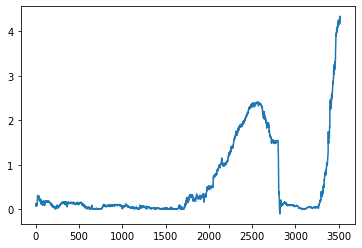

In [19]:
plt.plot(stock_data_stationary['^IRX']['Close'])

## Preprocessing

In [20]:
window_size = 10
stationary = True
X, y, df_stock = hp.prepare_data(stock_data_stationary, STOCK, fromDate, toDate, lag, stationary=stationary)

## XGBoost

In [21]:
loss_fn = 'reg:squarederror' #'reg:pseudohubererror'
xgboost_model_stationary = XGBoost(loss_fn)
xgboost_stock_predictor_stationary = StockPredictor(xgboost_model_stationary, window_size=window_size, stationary=stationary)
xgboost_stock_predictor_stationary.fit_predict(X, y, df_stock)
xgboost_stock_predictor_stationary.print_metrics()

Processing: 100%|██████████| 3243/3243 [01:48<00:00, 29.84it/s]

Mean Squared Error (MSE): 118.2247
Mean Absolute Error (MAE): 6.4841


In [ ]:
true_returns = xgboost_stock_predictor_stationary.true_returns
predicted_returns = xgboost_stock_predictor_stationary.predicted_returns
plt.figure(figsize=(12, 6))
plt.plot(true_returns, label='True Returns', linestyle='-', alpha=0.5)
plt.plot(predicted_returns, label='Predicted Returns', linestyle='--', alpha=0.5)
plt.title('True vs. Predicted Returns')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid(True)
plt.show()


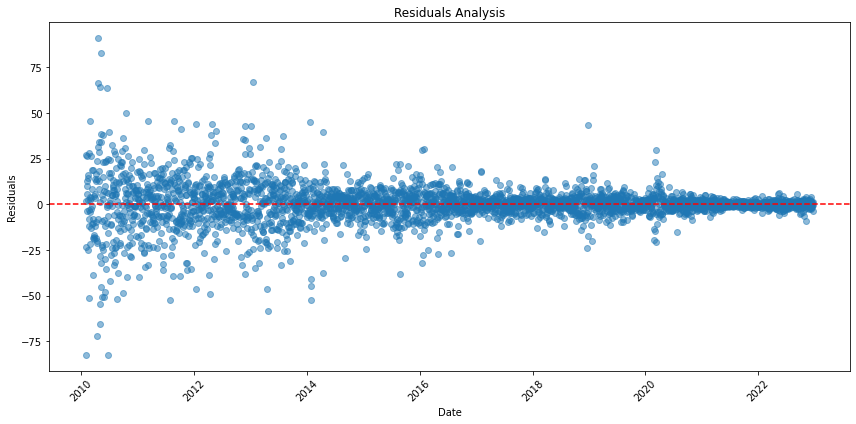

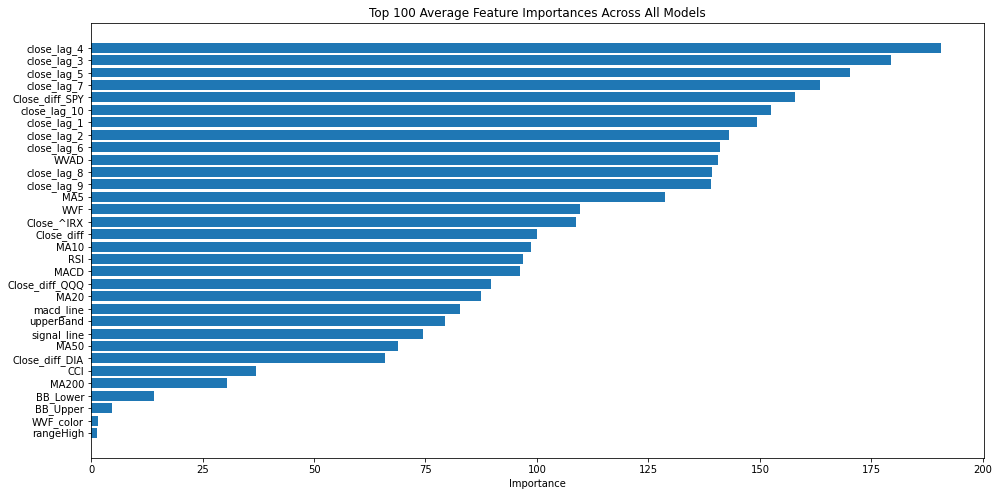

In [22]:
xgboost_stock_predictor_stationary.plot_residuals()
xgboost_stock_predictor_stationary.show_feature_importance(n=100)

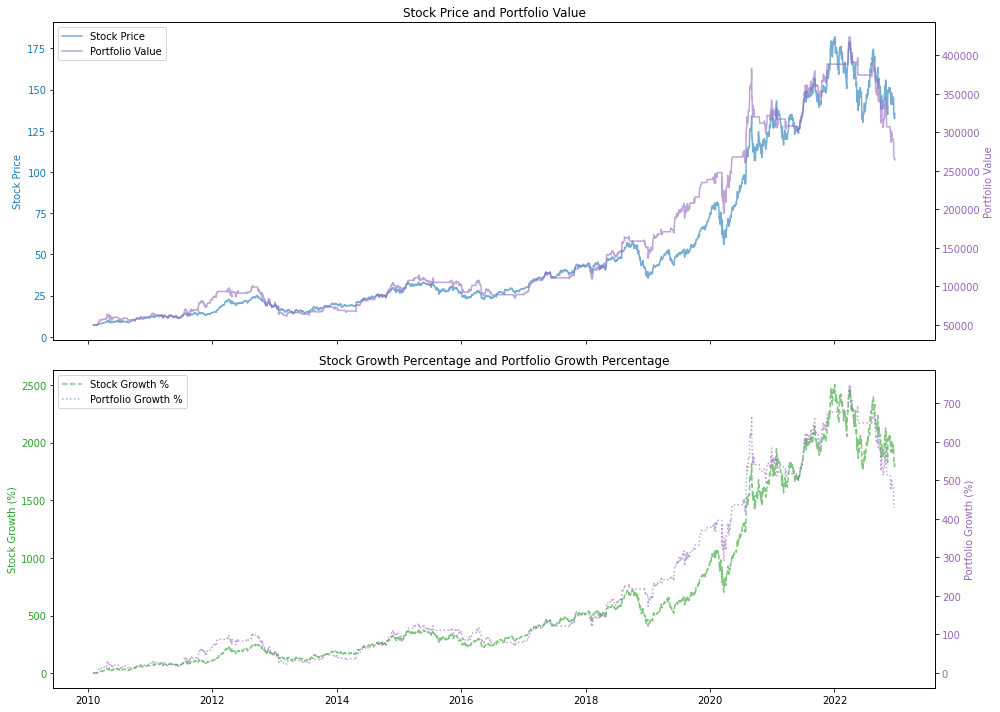

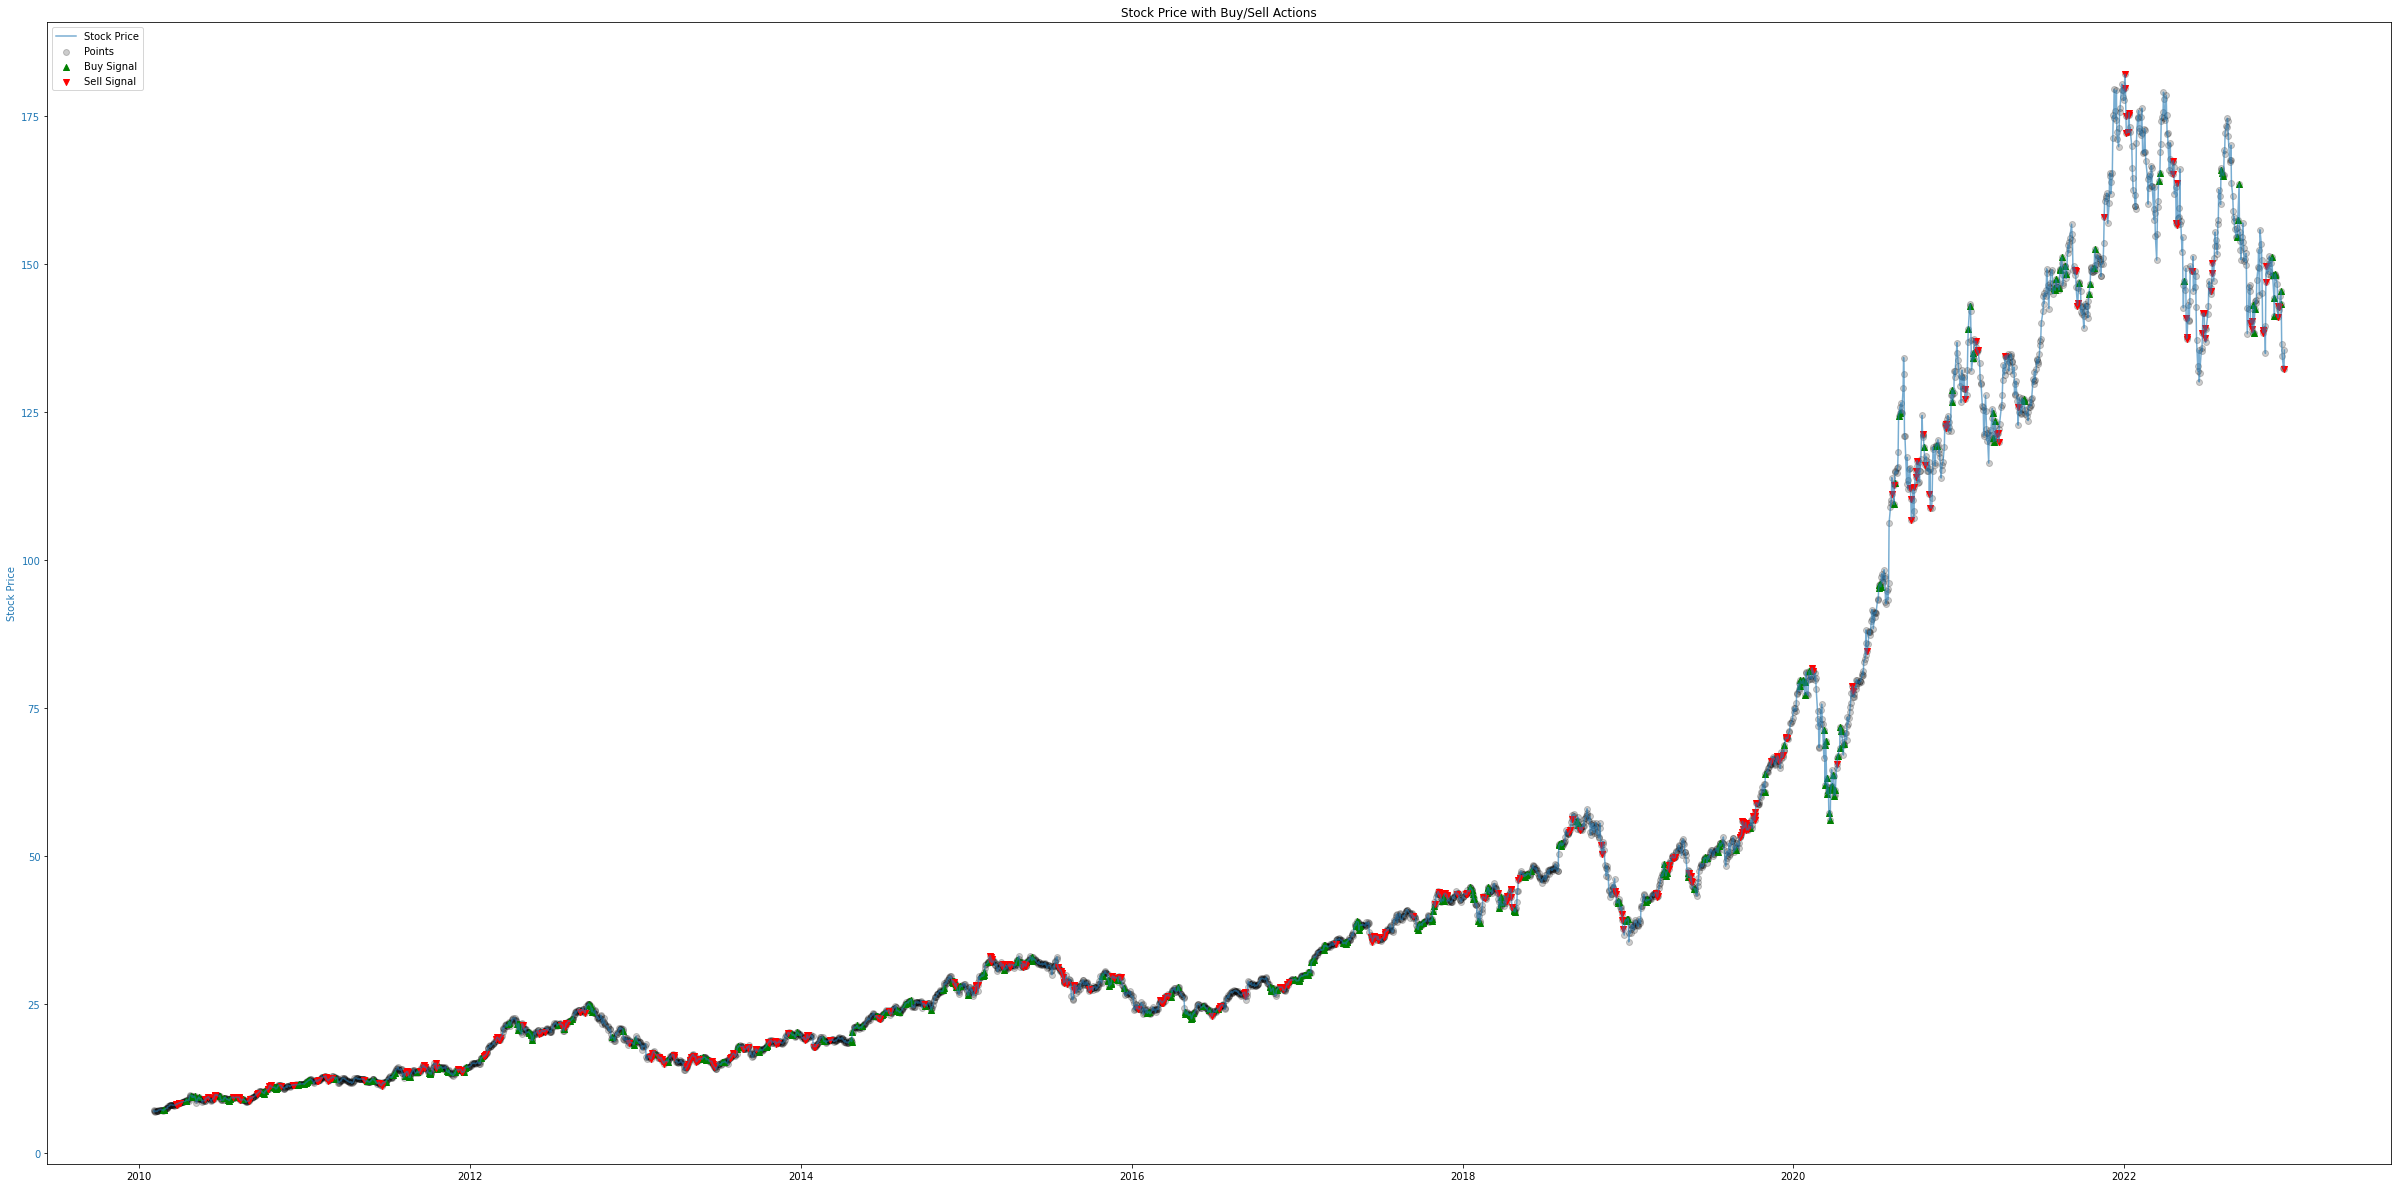

In [23]:
hp.trading_strategy(df_stock=df_stock, window_size=window_size, 
    true_returns=xgboost_stock_predictor_stationary.true_returns,
    predicted_returns=xgboost_stock_predictor_stationary.predicted_returns,
    starting_funds=50000
)

## Random Forest

In [24]:
# loss_fn = "squared_error" #'absolute_error', 'poisson', 'friedman_mse', 'squared_error'
# rf_model = RandomForest(loss_fn)
# rf_stock_predictor = StockPredictor(rf_model, window_size=window_size, stationary=stationary)
# rf_stock_predictor.fit_predict(X, y, df_stock)
# rf_stock_predictor.print_metrics()
# rf_stock_predictor.plot_residuals()
# rf_stock_predictor.show_feature_importance(n=100)
# hp.trading_strategy(df_stock=df_stock, window_size=window_size, 
#     true_returns=xgboost_stock_predictor.true_returns,
#     predicted_returns=xgboost_stock_predictor.predicted_returns,
#     starting_funds=50000
# )

## LSTM